In [ ]:
%pip install torch
%pip install torchdiffeq

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 1 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

## Synthetic part
import numpy as np
from scipy.integrate import solve_ivp

torch.manual_seed(67)
np.random.seed(67)


In [4]:
# 2.1  Helper Function to Load Load real double pendulum data from a Trial folder
import os

# Physical link lengths (for reference / positions if needed)
# L1_mm = 171.45
# L2_mm = 143.0
# L1 = L1_mm / 1000.0  # 0.17145 m
# L2 = L2_mm / 1000.0  # 0.14300 m

import numpy as np

def load_trial_from_raw(trial_name, base_dir=".",
                        T_window=5.0, num_points=1000,
                        vel_threshold_ratio=0.05):
    """
    Use ONLY DPmean_data_RB0/1.npy for a given trial:
    returns t_eval (num_points,), Y_true (num_points, 4) = [θ1, ω1, θ2, ω2].
    """
    data0 = np.load(os.path.join(base_dir, trial_name, "DPmean_data_RB0.npy"))
    data1 = np.load(os.path.join(base_dir, trial_name, "DPmean_data_RB1.npy"))

    t_raw = data0[0]
    phi1  = data0[1]
    phi2  = data1[1]

    # angular velocities
    omega1 = np.gradient(phi1, t_raw)
    omega2 = np.gradient(phi2, t_raw)

    Y_raw = np.stack([phi1, omega1, phi2, omega2], axis=-1)

    # detect motion start
    vel_mag = np.sqrt(omega1**2 + omega2**2)
    threshold = vel_threshold_ratio * vel_mag.max()
    start_idx = np.argmax(vel_mag > threshold)
    t_start   = t_raw[start_idx]

    print(f"[{trial_name}] motion start index {start_idx}, time {t_start:.4f}s")

    # 5-second window from motion start
    t_end = t_start + T_window
    mask  = (t_raw >= t_start) & (t_raw <= t_end)
    t_seg = t_raw[mask]
    Y_seg = Y_raw[mask]

    # resample to num_points
    t_eval = np.linspace(t_seg[0], t_seg[-1], num_points)
    Y_true = np.empty((num_points, 4), dtype=np.float32)
    for j in range(4):
        Y_true[:, j] = np.interp(t_eval, t_seg, Y_seg[:, j])

    # shift so window starts at 0
    t_eval = t_eval - t_eval[0]

    print(f"[{trial_name}] t_eval shape {t_eval.shape}, Y_true shape {Y_true.shape}")
    return t_eval, Y_true

# Load all three trials into a dict
real_trials = {}
for name in ["Trial1", "Trial2", "Trial3"]:
    real_trials[name] = load_trial_from_raw(name)




[Trial1] motion start index 929, time 1.8580s
[Trial1] t_eval shape (1000,), Y_true shape (1000, 4)
[Trial2] motion start index 1202, time 2.4040s
[Trial2] t_eval shape (1000,), Y_true shape (1000, 4)
[Trial3] motion start index 1029, time 2.0580s
[Trial3] t_eval shape (1000,), Y_true shape (1000, 4)


In [5]:
# 2.2 Prepare train/test tensors and global normalization

def prepare_train_test_tensors(real_trials, train_names, test_name):
    """
    real_trials: dict {trial_name: (t_eval_np, Y_true_np)}
    train_names: list of trial names to train on
    test_name  : single trial name for testing

    Returns
    -------
    train_trials : list of (t_train, Y_train_norm) torch tensors
    test_tensors : (t_test, Y_test, Y_test_norm) torch tensors
    Y_mean, Y_std: normalization stats (torch, shape (4,))
    dt           : float, time step (assumed same for all trials)
    """

    # Collect training trajectories as torch tensors
    t_train_list = []
    Y_train_list = []
    for name in train_names:
        t_np, Y_np = real_trials[name]
        t_train_list.append(torch.tensor(t_np, dtype=torch.float32))
        Y_train_list.append(torch.tensor(Y_np, dtype=torch.float32))

    # Global normalization stats across all training trials
    all_Y_train = torch.cat(Y_train_list, dim=0)   # (sum_T, 4)
    Y_mean = all_Y_train.mean(dim=0)
    Y_std  = all_Y_train.std(dim=0)

    # Apply normalization
    train_trials = []
    for t_torch, Y_torch in zip(t_train_list, Y_train_list):
        Y_norm = (Y_torch - Y_mean) / Y_std
        train_trials.append((t_torch, Y_norm))

    # Test trial
    t_test_np, Y_test_np = real_trials[test_name]
    t_test  = torch.tensor(t_test_np, dtype=torch.float32)
    Y_test  = torch.tensor(Y_test_np, dtype=torch.float32)
    Y_test_norm = (Y_test - Y_mean) / Y_std

    # Time step (assume uniform)
    dt = float(t_train_list[0][1] - t_train_list[0][0])

    return train_trials, (t_test, Y_test, Y_test_norm), Y_mean, Y_std, dt


In [6]:
# 3 ODE Function


# ODE function f in dy/dt = f(t,y)
class ODEFunc(nn.Module):
  def __init__(self, in_dim = 4, out_dim=4, hidden = (128,128),act=nn.Tanh):
    # num_in_out = 4 for the 2 angles and 2 angular velocities (or whichever parameters you want)
    super().__init__()
    dims = [in_dim, *hidden, out_dim]

    # The following is an MLP with x hidden layers
    layers = []
    for i in range(len(dims) - 1):
      layers.append(nn.Linear(dims[i], dims[i+1]))
      if i < len(dims) - 2:           # no activation after last Linear
        layers.append(act())
    self.net = nn.Sequential(*layers)

  def forward(self, t, y):
    # takes (4,) or (B,4) and returns same shape

    # y is a torch vector representing the current state
    # t is there just to match the expected function signature
    # need to make sure that the shapes are of form (B, 4)
    squeezed = False
    if y.dim() == 1:
      y = y.unsqueeze(0)  # (1,4)
      squeezed = True
    dy = self.net(y)         # (B,4)
    return dy.squeeze(0) if squeezed else dy # if y is (4,), Linear wants (B,4)

In [7]:
#4.1 Neural ODE model

class NeuralODE(nn.Module):
    def __init__(self, odefunc, method='dopri5', rtol=1e-6, atol=1e-6, step_size=None):
        """
        odefunc   : instance of ODEFunc
        method    : 'euler', 'midpoint', 'rk4', 'dopri5', 'bosh3', ...
        rtol, atol: tolerances for adaptive solvers (ignored by some fixed-step methods)
        step_size : used only for fixed-step methods like 'euler', 'midpoint', 'rk4'
        """
        super().__init__()
        self.odefunc   = odefunc
        self.method    = method
        self.rtol      = rtol
        self.atol      = atol
        self.step_size = step_size
        self._odeint   = odeint

    def forward(self, y0, t):
        # For fixed-step methods, pass step_size via options
        options = None
        if self.method in ["euler", "midpoint", "rk4"] and self.step_size is not None:
            options = {"step_size": self.step_size}

        return self._odeint(
            self.odefunc,
            y0,
            t,
            method=self.method,
            rtol=self.rtol,
            atol=self.atol,
            options=options,
        )


In [8]:
# 4.2 Make the Neural ODE

def make_neural_ode(method_name, dt, func_hidden=(10, 10, 10, 10), seed=None):
    """
    Create ODEFunc + NeuralODE with the desired solver method.

    method_name: "euler", "midpoint", "rk4", "dopri5", or "bosh3"
    dt         : time step (used as step_size for fixed-step methods)
    func_hidden: tuple specifying hidden layer sizes for ODEFunc
    seed       : if not None, sets torch + numpy seed before init (for reproducibility)
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    func = ODEFunc(in_dim=4, out_dim=4, hidden=func_hidden)

    if method_name in ["euler", "midpoint", "rk4"]:
        # Fixed-step methods: use step_size=dt
        neural_ode = NeuralODE(
            func,
            method=method_name,
            rtol=1e-6,
            atol=1e-6,
            step_size=dt,
        )
    elif method_name == "dopri5":
        neural_ode = NeuralODE(
            func,
            method="dopri5",
            rtol=1e-5,
            atol=1e-7,
        )
    elif method_name == "bosh3":
        neural_ode = NeuralODE(
            func,
            method="bosh3",
            rtol=1e-5,
            atol=1e-7,
        )
    else:
        raise ValueError(f"Unknown method: {method_name}")

    return func, neural_ode


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_train_train_test(
    neural_ode,
    Y_mean, Y_std,
    train_trial_name1,
    train_trial_name2,
    real_trials,
    test_trial_name,
    title_prefix="",
):
    """
    Plots prediction vs truth for:
      - training trial 1
      - training trial 2
      - held-out test trial

    Layout: 4 rows (θ1, ω1, θ2, ω2) × 3 columns (Train1 | Train2 | Test)
    """

    dev = next(neural_ode.parameters()).device
    Y_mean_d = Y_mean.to(dev)
    Y_std_d  = Y_std.to(dev)

    def predict_for_trial(trial_name):
        t_np, Y_np = real_trials[trial_name]          # numpy
        t = torch.tensor(t_np, dtype=torch.float32, device=dev)
        Y = torch.tensor(Y_np, dtype=torch.float32, device=dev)

        Y_norm = (Y - Y_mean_d) / Y_std_d
        y0     = Y_norm[0]

        neural_ode.eval()
        with torch.no_grad():
            Y_pred_norm = neural_ode(y0, t)          # (T,4)

        Y_pred = (Y_pred_norm * Y_std_d + Y_mean_d).cpu().numpy()
        return t_np, Y_np, Y_pred

    # --- run model for 3 trials ---
    t1_np, Y1_np, Y1_pred = predict_for_trial(train_trial_name1)
    t2_np, Y2_np, Y2_pred = predict_for_trial(train_trial_name2)
    tt_np, Yt_np, Yt_pred = predict_for_trial(test_trial_name)

    # --- RMSEs ---
    rmse_train1 = np.sqrt(((Y1_pred - Y1_np)**2).mean(axis=0))
    rmse_train2 = np.sqrt(((Y2_pred - Y2_np)**2).mean(axis=0))
    rmse_test   = np.sqrt(((Yt_pred - Yt_np)**2).mean(axis=0))

    print(f"Train1 RMSE [θ1, ω1, θ2, ω2] ({train_trial_name1}) =", rmse_train1)
    print(f"Train2 RMSE [θ1, ω1, θ2, ω2] ({train_trial_name2}) =", rmse_train2)
    print(f"Test   RMSE [θ1, ω1, θ2, ω2] ({test_trial_name})   =", rmse_test)

    # --- plotting: 4 rows × 3 cols ---
    names = [r"$\theta_1$", r"$\omega_1$", r"$\theta_2$", r"$\omega_2$"]
    fig, axs = plt.subplots(4, 3, figsize=(18, 10), sharex='col')

    # column 0: Train trial 1
    # column 1: Train trial 2
    # column 2: Test trial
    for i in range(4):
        # Train 1
        ax = axs[i, 0]
        ax.plot(t1_np, Y1_np[:, i], label="true", linewidth=1.2)
        ax.plot(t1_np, Y1_pred[:, i], label="model", alpha=0.8)
        ax.set_ylabel(names[i])
        if i == 0:
            ax.set_title(f"In Training Error on: {train_trial_name1}")
            ax.legend()

        # Train 2
        ax = axs[i, 1]
        ax.plot(t2_np, Y2_np[:, i], label="true", linewidth=1.2)
        ax.plot(t2_np, Y2_pred[:, i], label="model", alpha=0.8)
        if i == 0:
            ax.set_title(f"In Training Error on: {train_trial_name2}")
            ax.legend()

        # Test
        ax = axs[i, 2]
        ax.plot(tt_np, Yt_np[:, i], label="true", linewidth=1.2)
        ax.plot(tt_np, Yt_pred[:, i], label="model", alpha=0.8)
        if i == 0:
            ax.set_title(f"Out Training Error on: {test_trial_name}")
            ax.legend()

    axs[-1, 0].set_xlabel("time (s)")
    axs[-1, 1].set_xlabel("time (s)")
    axs[-1, 2].set_xlabel("time (s)")

    fig.suptitle(title_prefix, fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return rmse_train1, rmse_train2, rmse_test


In [10]:
# 6 Windowed Training Model
import torch.nn.functional as F
import numpy as np

def train_windowed_model(
    neural_ode,
    train_trials,
    max_epochs=600,
    window_size=100,
    num_windows_per_epoch=20,
    lr=1e-3,
    loss_mode="weighted",  # "weighted", "theta_only", or "full"
    method_name="unknown"
):
    """
    train_trials: list of (t_train, Y_train_norm) torch tensors
                  with shapes (T_i,), (T_i,4) in NORMALIZED space.
    """

    opt = torch.optim.Adam(neural_ode.parameters(), lr=lr)
    loss_hist = []

    for epoch in range(max_epochs):
        epoch_loss = 0.0

        for _ in range(num_windows_per_epoch):
            # choose a random trial
            trial_idx = np.random.randint(len(train_trials))
            t_trial, Y_trial = train_trials[trial_idx]
            T = t_trial.shape[0]
            if T <= window_size:
                continue

            # pick a random window start
            i = torch.randint(0, T - window_size, (1,)).item()
            t_window      = t_trial[i : i + window_size]
            Y_window_true = Y_trial[i : i + window_size]   # normalized
            y0_window     = Y_window_true[0]

            Y_window_pred = neural_ode(y0_window, t_window)

            if loss_mode == "theta_only":
                theta_true = Y_window_true[:, [0, 2]]
                theta_pred = Y_window_pred[:, [0, 2]]
                loss = F.mse_loss(theta_pred, theta_true)
            elif loss_mode == "weighted":
                weights = torch.tensor([1.0, 0.05, 1.0, 0.05],
                                       device=Y_window_true.device)
                sq_err = (Y_window_pred - Y_window_true) ** 2
                loss = (sq_err * weights).mean()
            else:  # "full"
                loss = F.mse_loss(Y_window_pred, Y_window_true)

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        epoch_loss /= num_windows_per_epoch
        loss_hist.append(epoch_loss)
        if epoch % 50 == 0:
            print(f"[{method_name}] epoch {epoch}: avg window loss = {epoch_loss:.6f}")

    return neural_ode, loss_hist


[dopri5] epoch 0: avg window loss = 0.085680
[dopri5] epoch 50: avg window loss = 0.062244
[dopri5] epoch 100: avg window loss = 0.054778
[dopri5] epoch 150: avg window loss = 0.038505
[dopri5] epoch 200: avg window loss = 0.068543
[dopri5] epoch 250: avg window loss = 0.057796
[dopri5] epoch 300: avg window loss = 0.059373
[dopri5] epoch 350: avg window loss = 0.043795
[dopri5] epoch 400: avg window loss = 0.047018
[dopri5] epoch 450: avg window loss = 0.041259
[dopri5] epoch 500: avg window loss = 0.024648
[dopri5] epoch 550: avg window loss = 0.026505
Saved weights to: Neural_ODE_train_Trial2+Trial3_test_Trial1_dopri5.pth
Train1 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [ 600.3979   425.13513 1529.8376  1118.1338 ]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial3) = [ 578.4088   409.41476 1011.9721  1200.9077 ]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial1)   = [ 438.32297  397.53537 1105.7869   709.3392 ]


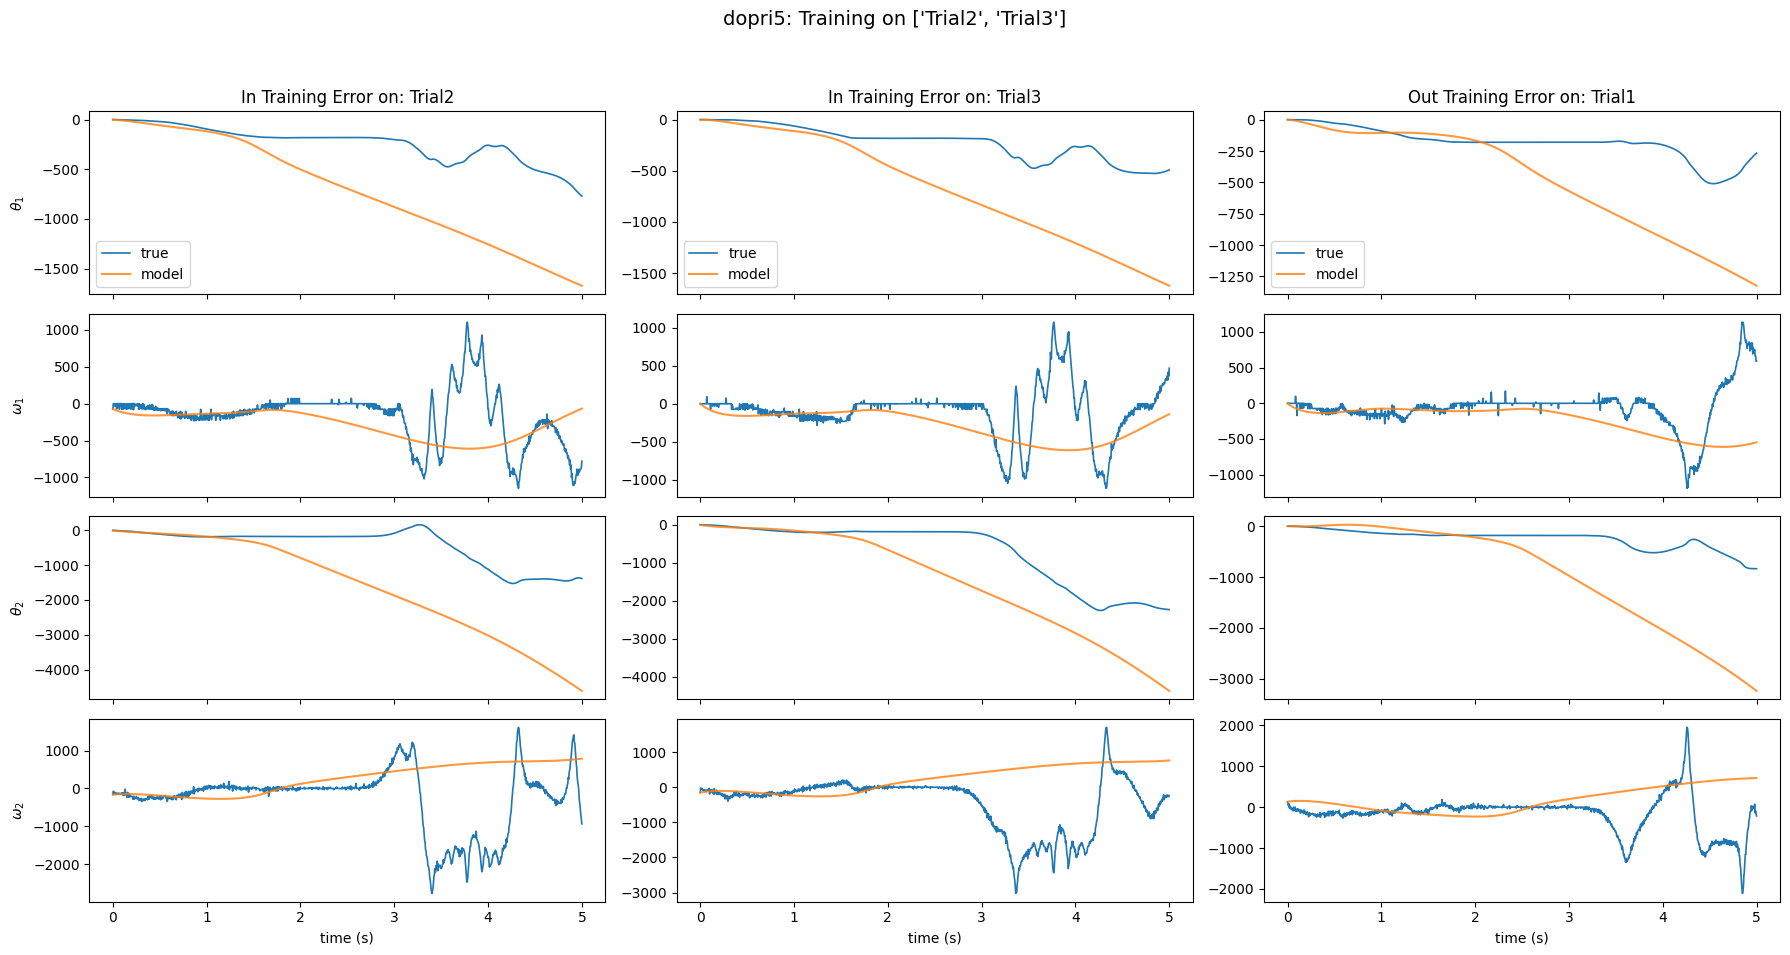

In [39]:
# 7.1 Code Block for Individual Solvers
# === Train on Trial1 + Trial2, test on Trial3, using dopri5 + windowed training ===

train_names = ["Trial2", "Trial3"]
test_name   = "Trial1"
method_name = "dopri5"

# 1) Prepare tensors + normalization
train_trials, test_tensors, Y_mean, Y_std, dt = prepare_train_test_tensors(
    real_trials, train_names, test_name
)
t_test, Y_test, Y_test_norm = test_tensors

# 2) Make model for this solver method
func, neural_ode = make_neural_ode(method_name, dt)

# 3) Train with windowed method
max_epochs = 600
window_size = 100
num_windows_per_epoch = 20
lr = 1e-3

neural_ode, loss_hist = train_windowed_model(
    neural_ode,
    train_trials,
    max_epochs=max_epochs,
    window_size=window_size,
    num_windows_per_epoch=num_windows_per_epoch,
    lr=lr,
    loss_mode="weighted",    # or "theta_only" / "full"
    method_name=method_name,
)

# 4) Save weights for later reuse
weights_path = f"Neural_ODE_train_{'+'.join(train_names)}_test_{test_name}_{method_name}.pth"
torch.save(func.state_dict(), weights_path)
print("Saved weights to:", weights_path)

# 4) Plot train vs test
rmse_train1, rmse_train2, rmse_test1= plot_train_train_test(
    neural_ode,
    Y_mean, Y_std,
    train_names[0], 
    train_names[1],
    real_trials=real_trials,
    test_trial_name=test_name,
    title_prefix=f"{method_name}: Training on {train_names}",
)
## Plot of Model on training 2
## Plot of model on training 3
## Plot of model on testing 1


Train1 RMSE [θ1, ω1, θ2, ω2] (Trial1) = [102.20301 290.57352 218.42566 564.8573 ]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [ 81.370026 356.9068   406.07944  819.99713 ]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial3)   = [ 84.88545 333.99026 851.2319  859.5167 ]


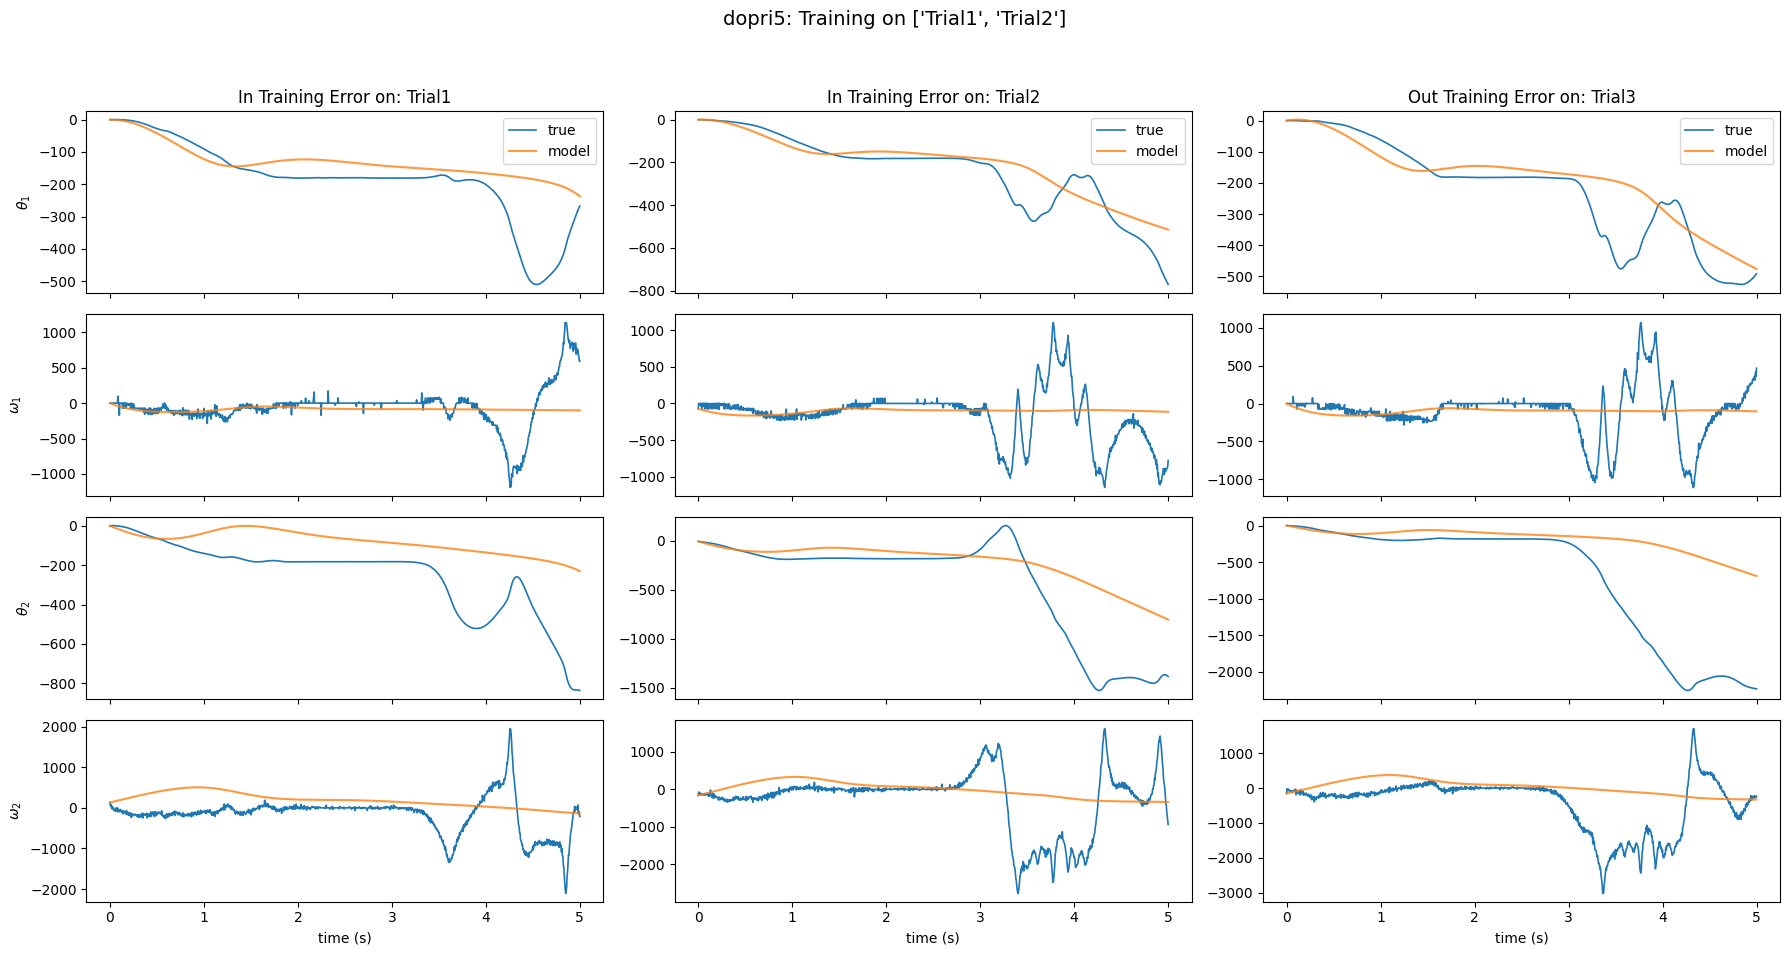

Train1 RMSE [θ1, ω1, θ2, ω2] (Trial1) = [ 66.008606 295.87335  108.49394  529.93195 ]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [116.71159 350.95865 317.39127 957.44434]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial3)   = [102.843544 333.5724   690.50226  973.8943  ]


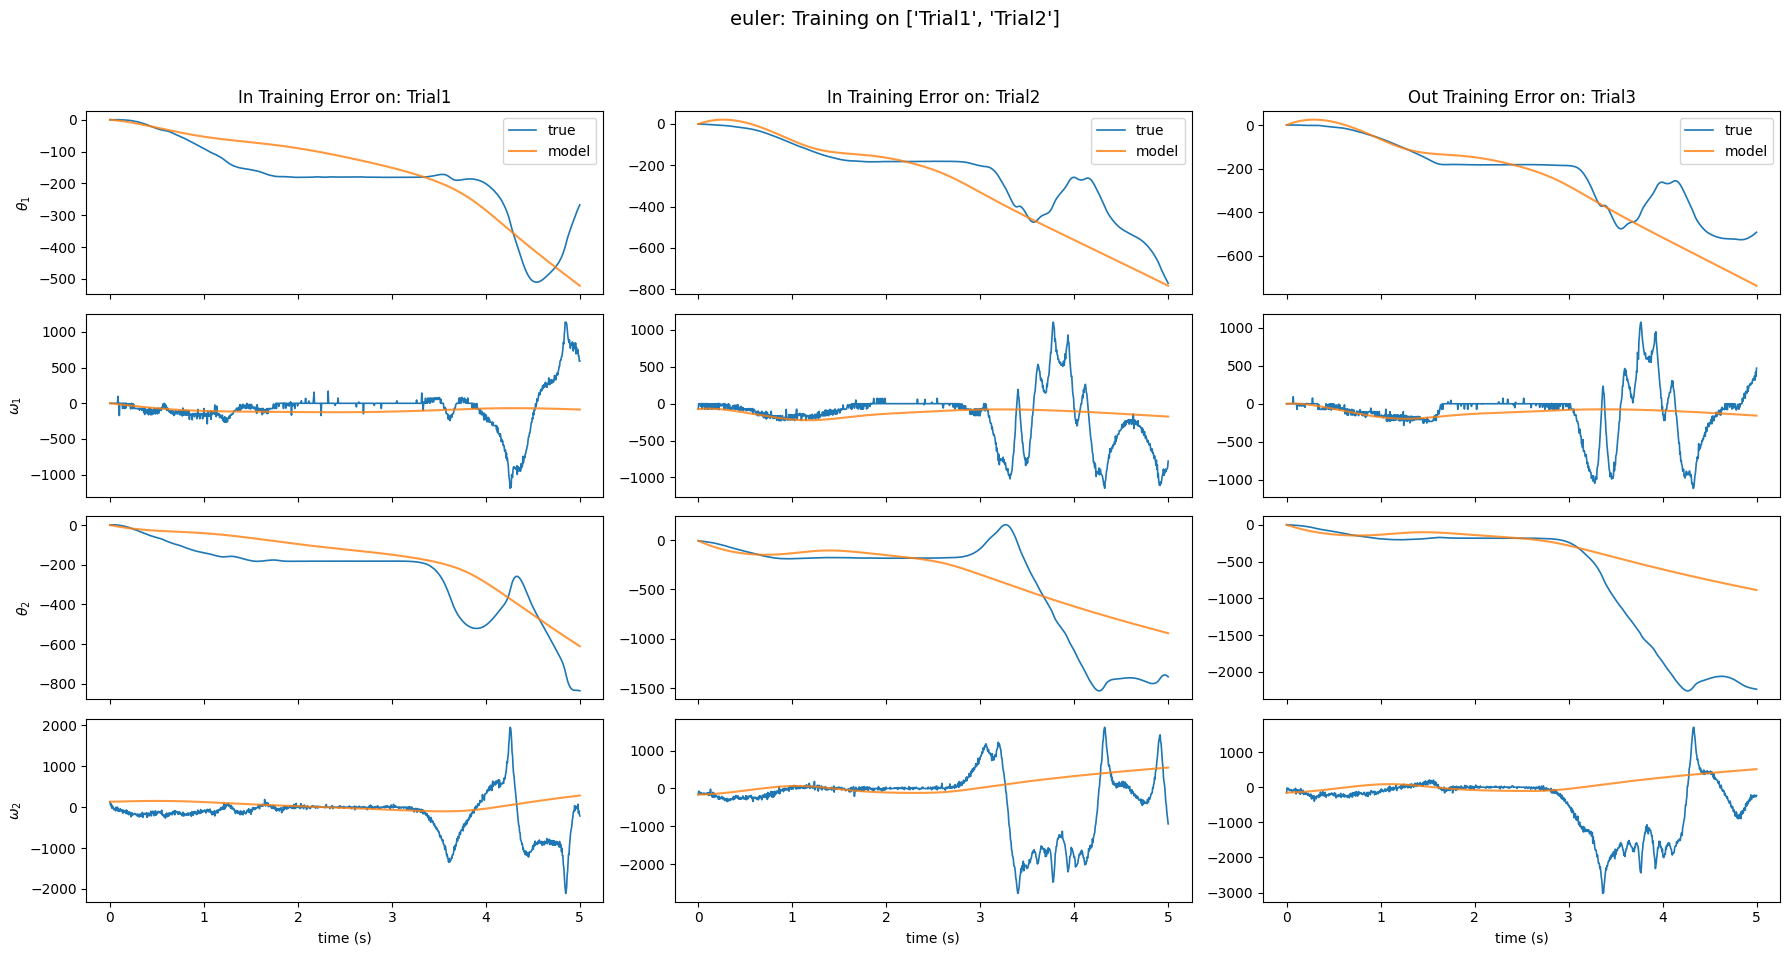

Train1 RMSE [θ1, ω1, θ2, ω2] (Trial1) = [183.05151 292.15265 103.62326 713.96326]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [ 195.66594  461.3134   403.4146  1111.4437 ]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial3)   = [ 197.49832  384.24323  739.1377  1209.7991 ]


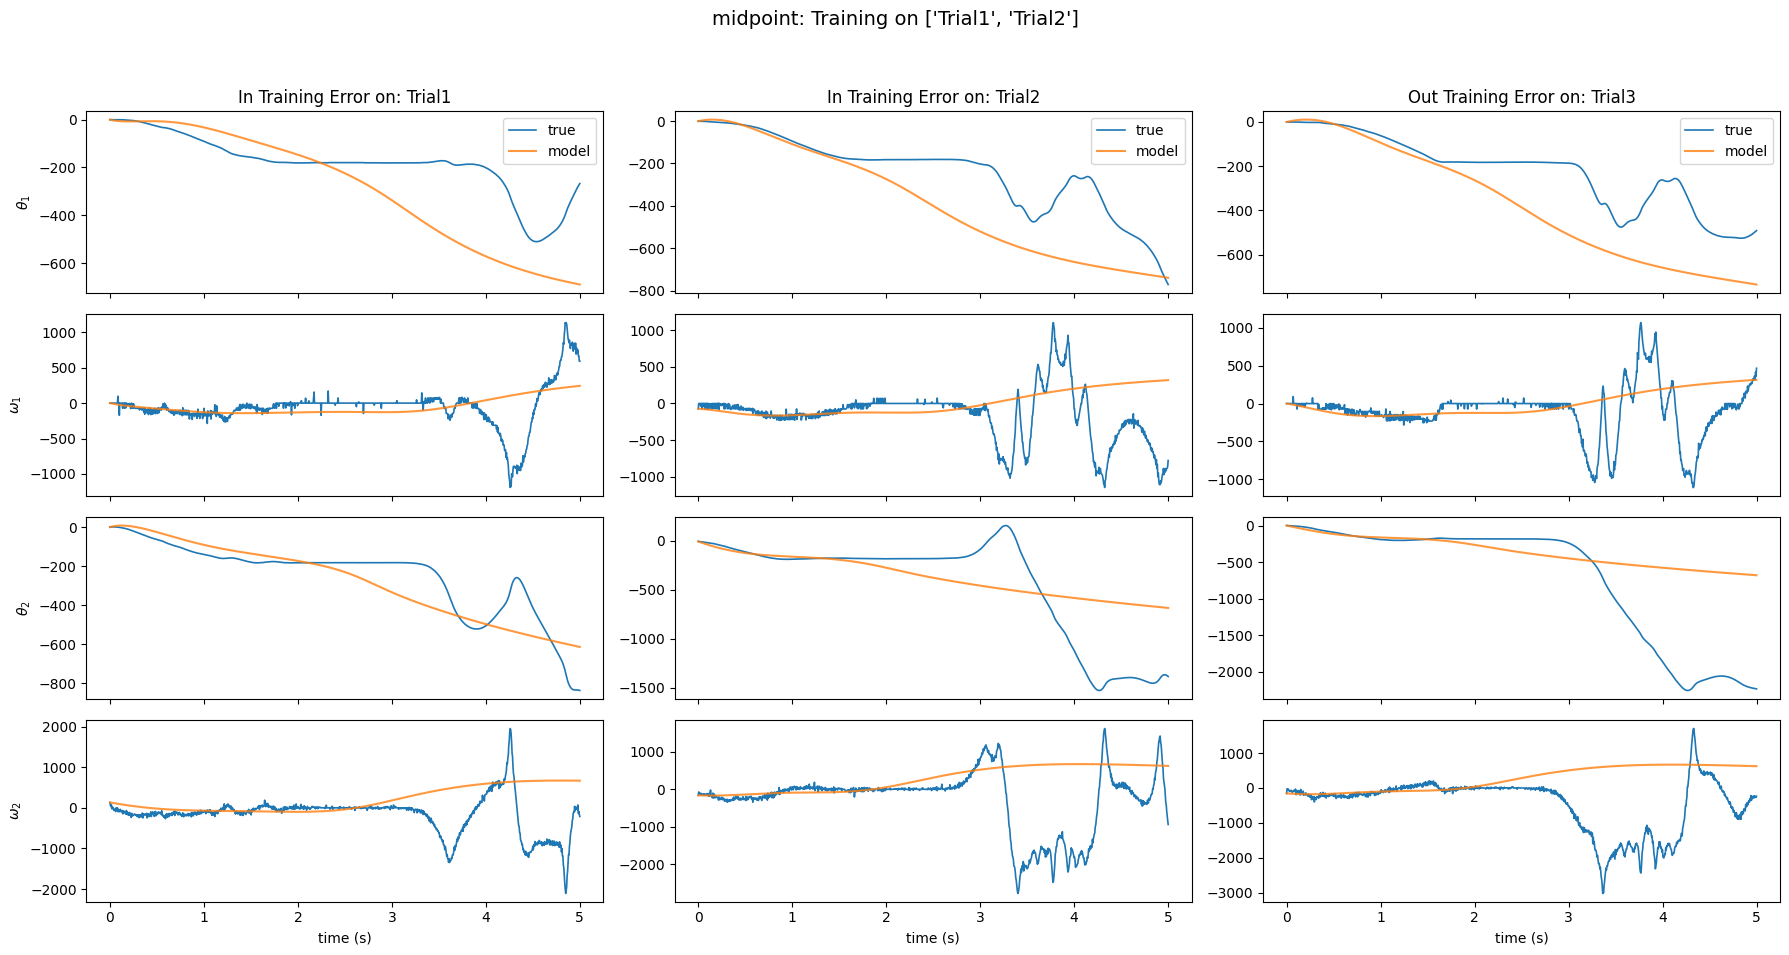

Train1 RMSE [θ1, ω1, θ2, ω2] (Trial1) = [ 52.137295 310.85016   86.63193  505.9528  ]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [107.76958 327.54852 243.57718 893.98444]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial3)   = [ 90.7831  351.8793  550.21246 906.12286]


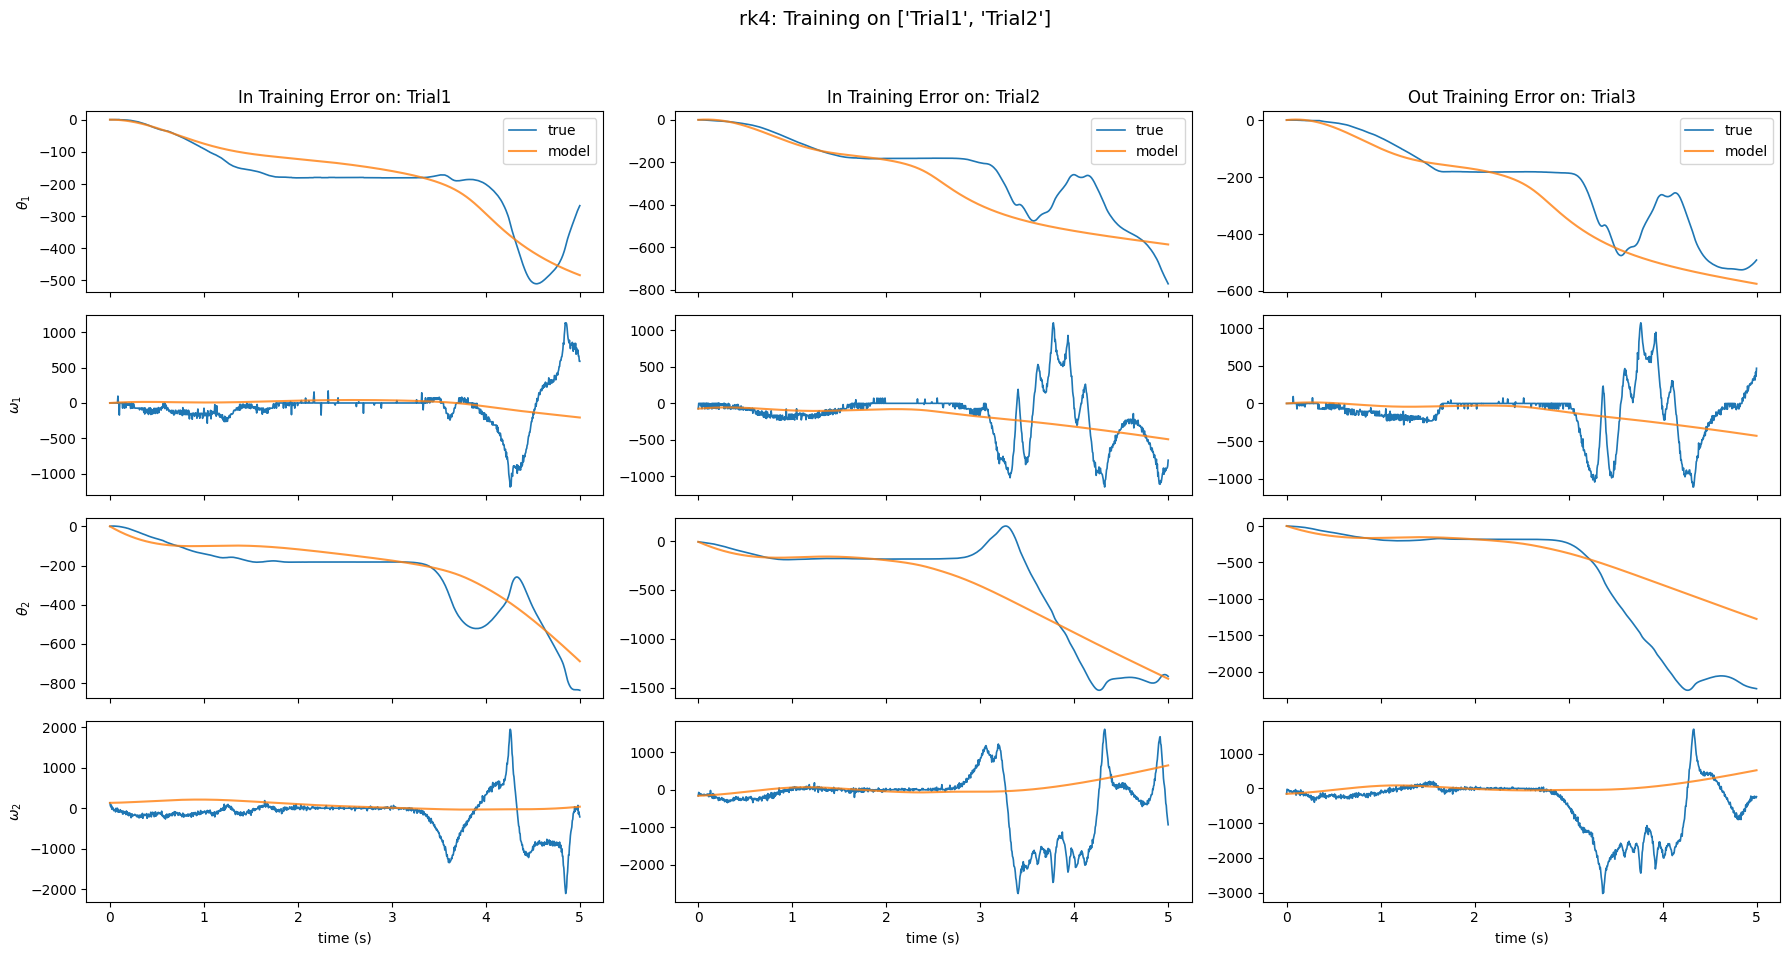

Train1 RMSE [θ1, ω1, θ2, ω2] (Trial1) = [ 62.028217 293.1252   139.99055  505.40125 ]
Train2 RMSE [θ1, ω1, θ2, ω2] (Trial2) = [ 74.53861 340.85184 312.7919  836.8658 ]
Test   RMSE [θ1, ω1, θ2, ω2] (Trial3)   = [ 63.07709 332.9836  727.1612  857.6255 ]


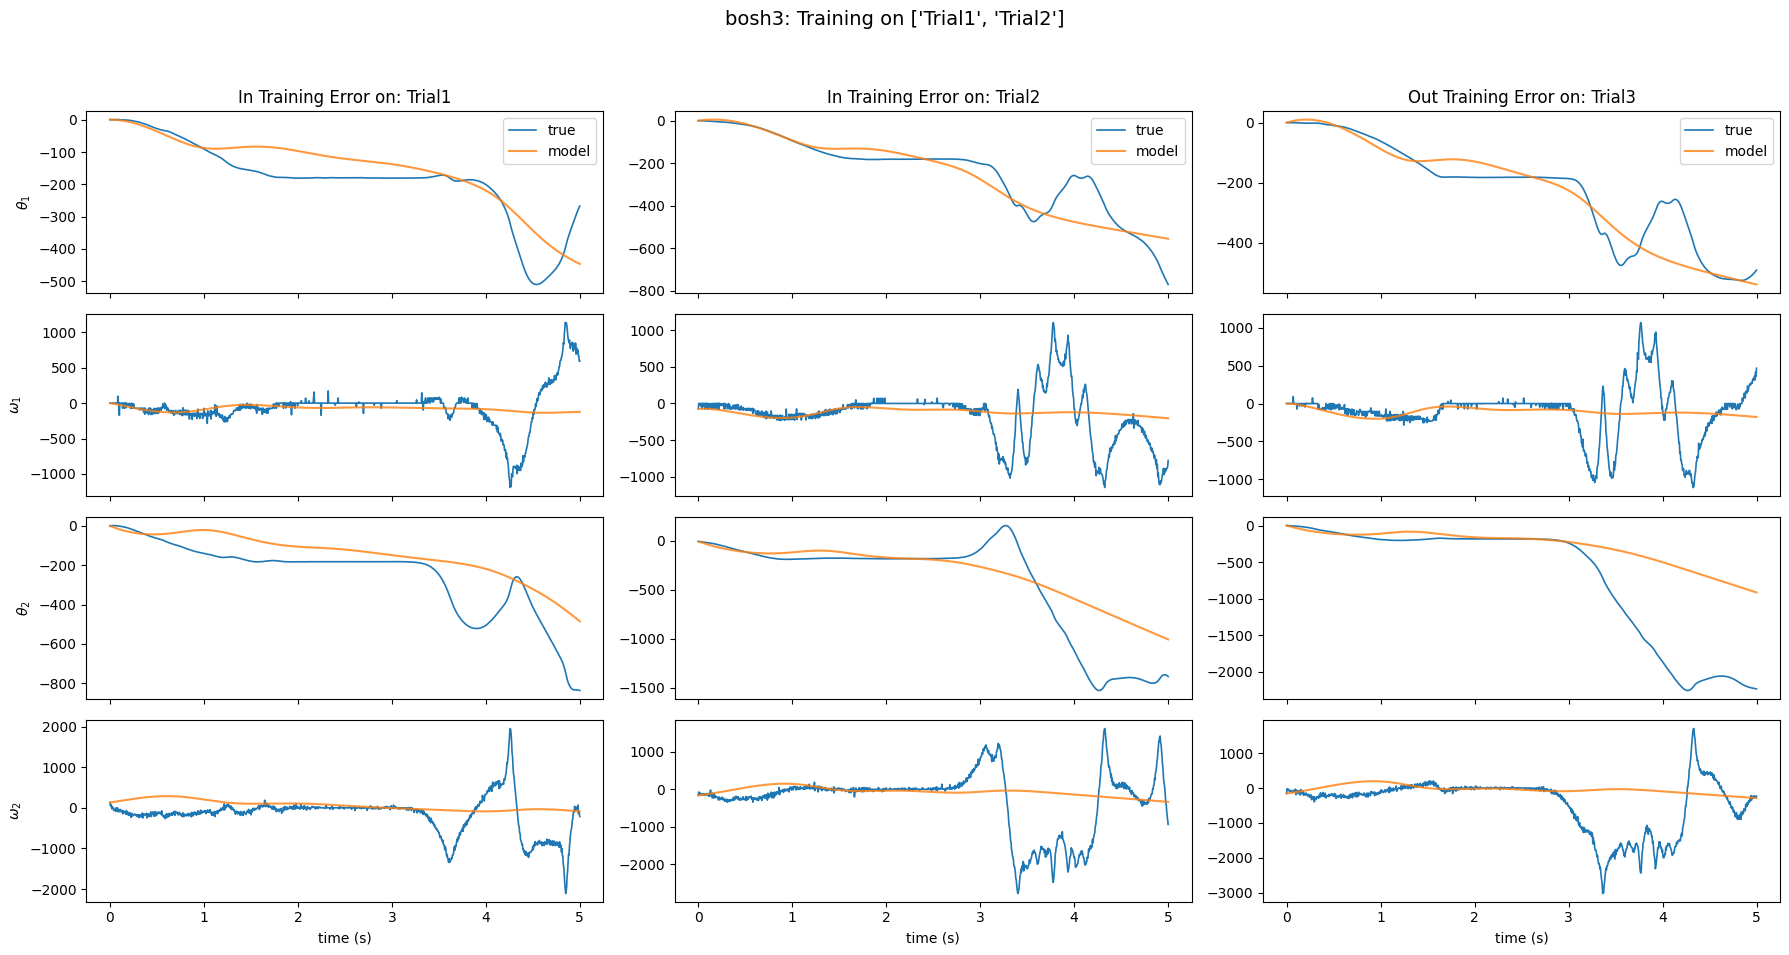

In [54]:
# 7.1.1 Given Weights: reload model and plot performance

# === Train on Trial1 + Trial2, test on Trial3, using dopri5 + windowed training ===
methods_to_try = [
    "dopri5",
    "euler",   
    "midpoint", 
    "rk4", 
    "bosh3"]

for method_name in methods_to_try:


    train_names = ["Trial2", "Trial3"]
    test_name   = "Trial1"
    method_name = method_name

    # 1) Prepare tensors + normalization
    train_trials, test_tensors, Y_mean, Y_std, dt = prepare_train_test_tensors(
        real_trials, train_names, test_name
    )
    t_test, Y_test, Y_test_norm = test_tensors

    # 2) Make model for this solver method
    func, neural_ode = make_neural_ode(method_name, dt)
    weights_path = f"Neural_ODE_train_Trial2+Trial3_test_Trial1_{method_name}.pth"
    # 3) Load weights into the ODEFunc that neural_ode wraps
    weights = torch.load(weights_path)

    func.load_state_dict(weights)


    # now the weights are loaded

    # 4) Plot train vs test
    rmse_train1, rmse_train2, rmse_test1= plot_train_train_test(
        neural_ode,
        Y_mean, Y_std,
        train_names[0], 
        train_names[1],
        real_trials=real_trials,
        test_trial_name=test_name,
        title_prefix=f"{method_name}: Training on {train_names}",
    )
    ## Plot of Model on training 2
    ## Plot of model on training 3
    ## Plot of model on testing 1
    

In [44]:
# 7.2 Code Block for ALL Solvers
# === Compare solvers with windowed training, for a fixed train/test split ===

train_names = ["Trial1", "Trial2"]
test_name   = "Trial3"

methods_to_try = [
    ("dopri5",   "dopri5"),
    ("euler",    "euler"),
    ("midpoint", "midpoint"),
    ("rk4",      "rk4"),
    ("bosh3",    "bosh3"),
]

results = {}

# Prepare data once
train_trials, test_tensors, Y_mean, Y_std, dt = prepare_train_test_tensors(
    real_trials, train_names, test_name
)
t_test, Y_test, Y_test_norm = test_tensors

for label, method_name in methods_to_try:
    print("\n====================================")
    print(f"Training with method: {method_name}")
    print("====================================")

    func, neural_ode = make_neural_ode(method_name, dt)

    neural_ode, loss_hist = train_windowed_model(
        neural_ode,
        train_trials,
        max_epochs=500,
        window_size=200,
        num_windows_per_epoch=20,
        lr=1e-3,
        loss_mode="weighted",
        method_name=method_name,
    )

    # Save weights
    weights_path = f"Neural_ODE_train_{'+'.join(train_names)}_test_{test_name}_{method_name}.pth"
    torch.save(func.state_dict(), weights_path)

    # Evaluate on test only (to avoid tons of plots, we plot just the test trial)
    _, Y_test_np = real_trials[test_name]
    t_test_np, _ = real_trials[test_name]

    Y_mean_d = Y_mean.to(t_test.device)
    Y_std_d  = Y_std.to(t_test.device)

    neural_ode.eval()
    with torch.no_grad():
        y0_test_norm = Y_test_norm[0]
        Y_test_pred_norm = neural_ode(y0_test_norm, t_test)
    Y_test_pred = (Y_test_pred_norm * Y_std_d + Y_mean_d).cpu().numpy()

    test_rmse = np.sqrt(((Y_test_pred - Y_test_np)**2).mean(axis=0))
    print(f"{method_name} test RMSE [θ1, ω1, θ2, ω2] =", test_rmse)

    results[method_name] = {
        "loss_hist": loss_hist,
        "test_rmse": test_rmse,
        "weights_path": weights_path,
    }

# You can then inspect 'results' to see which solver did best.




Training with method: dopri5
[dopri5] epoch 0: avg window loss = 0.434852
[dopri5] epoch 50: avg window loss = 0.224931
[dopri5] epoch 100: avg window loss = 0.129863
[dopri5] epoch 150: avg window loss = 0.130622
[dopri5] epoch 200: avg window loss = 0.141142
[dopri5] epoch 250: avg window loss = 0.056097
[dopri5] epoch 300: avg window loss = 0.079605
[dopri5] epoch 350: avg window loss = 0.065103
[dopri5] epoch 400: avg window loss = 0.087697
[dopri5] epoch 450: avg window loss = 0.037166
dopri5 test RMSE [θ1, ω1, θ2, ω2] = [ 62.807323 342.31912  765.17706  779.1575  ]

Training with method: euler
[euler] epoch 0: avg window loss = 0.212107
[euler] epoch 50: avg window loss = 0.087718
[euler] epoch 100: avg window loss = 0.117188
[euler] epoch 150: avg window loss = 0.031067
[euler] epoch 200: avg window loss = 0.087503
[euler] epoch 250: avg window loss = 0.096629
[euler] epoch 300: avg window loss = 0.048753
[euler] epoch 350: avg window loss = 0.080160
[euler] epoch 400: avg wind